## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion â€“ that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk


import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0   1        No         0   2  30.443518 -1.165083   1   1   3   2
1   3        No         0   3  32.159350 -0.645617   2   3   2   2
2   4        No         0   2  30.431659  0.133583   1   1   4   2
3   5        No         0   0  26.588914 -0.212728   2   1   4   2
4   8       Yes         0   3  28.044332 -0.385883   1   1   2   2

In [2]:
# define and test a baseline model for comparison
def baseline_model(df):
    ''' This baseline model randomly assigns Yes ann No values in an array of length(df)'''
    l1 = ["Yes", "No"]
    output = []
    for x in range(len(df)):
        rand = np.random.randint(0, 2)
        output.append(l1[rand])
    return np.asarray(output)


test_results(baseline_model)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0077.

Your nir with this strategy is -759.95.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0076729466319283316, -759.95000000000005)

In [3]:
# check for null values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [4]:
# find descriptive statistics on features
features_df = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
features_df.describe()

V1            V2            V3            V4            V5  \
count  84534.000000  84534.000000  84534.000000  84534.000000  84534.000000   
mean       1.500662     29.973600      0.000190      1.679608      2.327643   
std        0.868234      5.010626      1.000485      0.466630      0.841167   
min        0.000000      7.104007     -1.684550      1.000000      1.000000   
25%        1.000000     26.591501     -0.905350      1.000000      2.000000   
50%        2.000000     29.979744     -0.039572      2.000000      2.000000   
75%        2.000000     33.344593      0.826206      2.000000      3.000000   
max        3.000000     50.375913      1.691984      2.000000      4.000000   

                 V6            V7  
count  84534.000000  84534.000000  
mean       2.502898      1.701694  
std        1.117349      0.457517  
min        1.000000      1.000000  
25%        2.000000      1.000000  
50%        3.000000      2.000000  
75%        4.000000      2.000000  
max        4.000000      2.000000

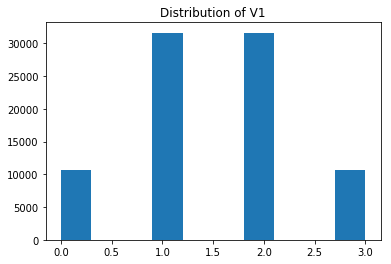

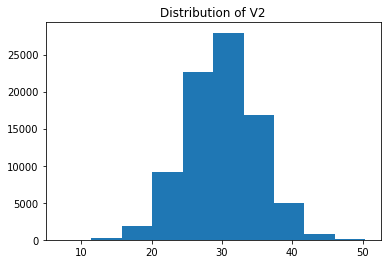

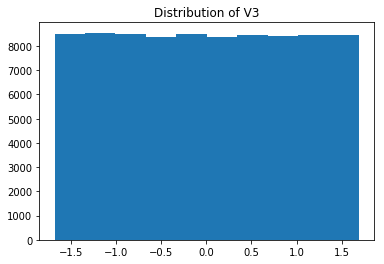

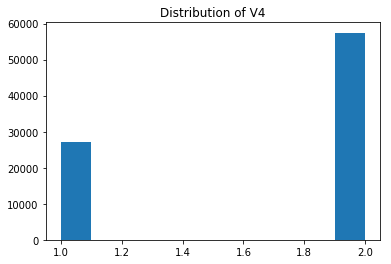

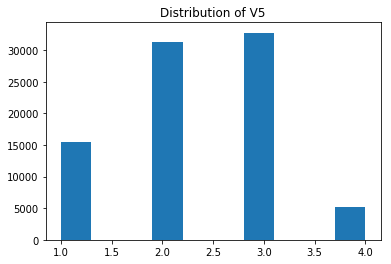

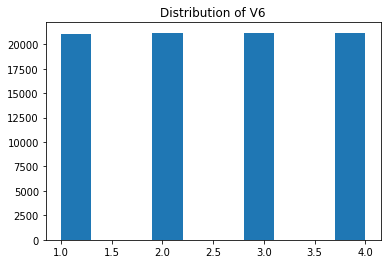

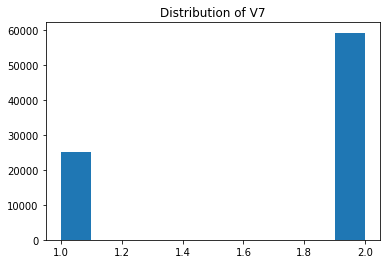

In [5]:
# find distributions of features
for feature in features_df.columns:
    plt.hist(features_df[feature])
    plt.title('Distribution of {}'.format(feature))
    plt.show()

`V2` and `V3` appear continuous.  The rest appear categorical and may need to be dummied out.

In [10]:
# dummy values assumed to be categorical
dummied = pd.get_dummies(train_data, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
dummied.columns

Index(['ID', 'Promotion', 'purchase', 'V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
       'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2', 'V5_3', 'V5_4', 'V6_1', 'V6_2',
       'V6_3', 'V6_4', 'V7_1', 'V7_2'],
      dtype='object')

In [11]:
# check sizes of experiement and control groups
dummied.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [8]:
# create function to test if control and experiment groups are statistically significant from a 50/50 split
def test_promotion_split(df, feature):
    treat = df[df['Promotion'] == 'Yes'][feature]
    cont = df[df['Promotion'] == 'No'][feature]
    n_total = len(treat) + len(cont)
    p = 0.5
    mu = p * n_total

    sd = np.sqrt(p*(1-p)*n_total)

    n_cont = len(cont)
    z = ((n_cont + 0.5) - n_total*p)/np.sqrt(n_total*p*(1-p))
    p_value = 2 * sp.stats.norm.cdf(z)

    print("________________\nmu : {}\nstdv: {}\nz-score: {}\np-value: {}".format(mu, sd, z, p_value))
    if p_value >=0.05:
        print("Fail to reject null hypothesis\nCongrats! This feature is balanced.")
    else:
        print("\n\nREJECT NULL HYPOTHESIS THAT THIS IS REASONABLE SPLIT\n\n")

# run function on overall population        
test_promotion_split(dummied, 'Promotion')

________________
mu : 42267.0
stdv: 145.3736564856233
z-score: -0.6638066506192843
p-value: 0.5068140685419046
Fail to reject null hypothesis
Congrats! This feature is balanced.


We failed to reject the nullk hypothesis that the number in the control and treatment groups were differently sized in a statistically significant way.

In [9]:
#create list of dummied categorical variables
features_list = ['V1_0', 'V1_1', 'V1_2', 'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2', 
                 'V5_3', 'V5_4', 'V6_1', 'V6_2', 'V6_3', 'V6_4', 'V7_1', 'V7_2']

# create function testing 
for feature in features_list:
    df = dummied[dummied[feature] == 1]
    test_promotion_split(df, feature)

________________
mu : 5312.5
stdv: 51.53882032022076
z-score: 0.5820855000871992
p-value: 1.4394909085614855
Fail to reject null hypothesis
Congrats! This feature is balanced.
________________
mu : 15815.5
stdv: 88.92553064221771
z-score: 0.2698887465351364
p-value: 1.212754155003
Fail to reject null hypothesis
Congrats! This feature is balanced.
________________
mu : 15804.0
stdv: 88.89319434017432
z-score: -1.0743229637416665
p-value: 0.28267795627902925
Fail to reject null hypothesis
Congrats! This feature is balanced.
________________
mu : 5335.0
stdv: 51.647846034466916
z-score: -1.035861204440105
p-value: 0.3002668990500855
Fail to reject null hypothesis
Congrats! This feature is balanced.
________________
mu : 13542.0
stdv: 82.28608630868283
z-score: -0.7109342857861388
p-value: 0.4771249585482401
Fail to reject null hypothesis
Congrats! This feature is balanced.
________________
mu : 28725.0
stdv: 119.84364814206884
z-score: -0.31290769749887426
p-value: 0.7543507892863371
Fail

The treatment and control portions within members of each categorical feature appear balanced, or rather, we fail to reject the null hypothesis that they're balanced.

In [19]:
# test whether the promotion led to a statistically significant increase in purchases within each group
p_null = dummied.purchase.mean()

def test_experiement_significance(sub_df, column):
    print('_____________')
    n_total = len(sub_df)
    n_cont = float(len(sub_df[sub_df['Promotion'] == 'No']))
    n_exper = float(len(sub_df[sub_df['Promotion'] == 'Yes']))
    
    mean_purchases = sub_df.groupby('Promotion').mean()['purchase']

    se_p = np.sqrt(p_null*(1-p_null)*(1/n_cont + 1/n_exper))
    
    z = (mean_purchases[1] - mean_purchases[0])/se_p
    
    p_val = 1 - sp.stats.norm.cdf(z)
    print('feature: {}\np-value: {}'.format(column, p_val))
    if p_val >= 0.05:
        print("\n!!!    INSUFFICIENT SIGNIFICANCE FOR\n!!!    PROMOTION MAKING A DIFFERENCE IN PURCHASES\n")
    

In [20]:
# find IRR and NIR for each feature group
def compute_IRR(p_treat, p_cont, num_treat, num_cont):
    print("IIR: {}".format((p_treat/num_treat) - (p_cont/num_cont)))
#
def compute_NIR(p_treat, num_treat, p_cont):
    print("NIR: {}".format((10*p_treat - 0.15*num_treat) - 10*p_cont))

In [21]:
for column in features_list:
    df1 = dummied[dummied[column] == 1]
    test_experiement_significance(df1, column)
    p_treat = df1[df1['Promotion'] == 'Yes'].sum()['purchase']
    print("purchases by treatment group: {}".format(p_treat))
    p_cont = df1[df1['Promotion'] == 'No'].sum()['purchase']
    print("purchases by control group: {}".format(p_cont))
    num_treat = len(df1[df1['Promotion'] == 'Yes'])
    num_cont = len(df1[df1['Promotion'] == 'No'])
    compute_IRR(p_treat, p_cont, num_treat, num_cont)
    compute_NIR(p_treat, num_treat, p_cont)

_____________
feature: V1_0
p-value: 1.1580656755771912e-07
purchases by treatment group: 98
purchases by control group: 40
IIR: 0.011062233977679515
NIR: -212.44999999999993
_____________
feature: V1_1
p-value: 2.5423759764109377e-09
purchases by treatment group: 252
purchases by control group: 138
IIR: 0.007244775554012248
NIR: -1228.7999999999997
_____________
feature: V1_2
p-value: 0.0
purchases by treatment group: 302
purchases by control group: 103
IIR: 0.012436542369949698
NIR: -395.0
_____________
feature: V1_3
p-value: 0.00430059367142277
purchases by treatment group: 69
purchases by control group: 38
IIR: 0.005608252821598726
NIR: -498.35
_____________
feature: V4_1
p-value: 0.5838376467524564

!!!    INSUFFICIENT SIGNIFICANCE FOR
!!!    PROMOTION MAKING A DIFFERENCE IN PURCHASES

purchases by treatment group: 95
purchases by control group: 98
IIR: -0.0002836315436208197
NIR: -2070.1499999999996
_____________
feature: V4_2
p-value: 0.0
purchases by treatment group: 626
purcha

On their own, it appears the total population of the members of any given categorical feature don't purchase at a high enough rate to cover the costs of offering the promotion to all members of that group. We'll likely need to look into interactions between groups. Also, we failed to reject the null hypothesis that V4_1 increased their purchases at all when offered the promotion.

Based on these features, I'd assign "Yes" to all customers with a `V1` value of 0 or 2, a `V4` value of 2, and a `V5` value of 1 or 3. I'll also check the population size. If it seems low, I will conduct more testing to see if the size is in fact large enough to have statistically significant and reliable enough results to know that providing our promotion to this subset of the population will earn us money.

In [32]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = []
    size = 1
    for index, row in df.iterrows():
        if row['V1'] == 0 or row['V1'] == 2:
            if row['V4'] == 2:
                if row['V5'] == 1 or row['V5'] == 3:
                    promotion.append('Yes')
                    size += 1
                else:
                    promotion.append('No')  
            else:
                promotion.append('No')
        else:
            promotion.append('No')
    
    promotion = np.asarray(promotion)
    
    print("Size of Promotion population: {}".format(size))
    
            
    
    
    
    return promotion

In [33]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Size of Promotion population: 8017
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0228.

Your nir with this strategy is 298.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.022793834704630447, 298.10000000000002)

Our IRR and NIR are significantly higher than Udacity's model, with a substantially large population receiving the promotion that I'm not too worried the results are significant, though we may run further tests and analysis to expand this size and maximize profits, and depending on future subsets of the population may run into minimum size issues. These results are better than the comparative model even without incorporating the continuous features, so I'll stop here for now, but those would be another route to explore to further improve my model.